# Final Project  - Gapfilling Satellite Soil Moisture Time Series using Machine Learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import utils as utils
import cartopy.crs as ccrs
from scipy.stats import theilslopes
import ipywidgets as widgets
from statsmodels.tsa.stattools import adfuller
from pytesmo.time_series.anomaly import calc_anomaly, calc_climatology
import pytesmo
#from pytesmo.interpolate.dctpls import smoothn
import pickle

np.random.seed(123)

# Data Selection
The following cell will load the data sample for the rest of the notebook from the available test locations. The time series data will be stored in the global variable `DATA` and the longitude and latitude of the test location as `LON` and `LAT`, respectively.

**Data will be used as selected here when running other cells of this notebook**

In [4]:
@widgets.interact(
    location=widgets.Dropdown(
        options=['Romania', 'Spain1', 'Spain2', 'Austria', 'Germany1', 'Germany2', 'Italy', 'Netherlands'],
        description='Select location:', style={'description_width': '120px'}, layout=widgets.Layout(width='300px')),
    period=widgets.IntRangeSlider(
        value=[2015, 2020], min=2015, max=2020, step=1, description="Period [year]", 
        layout=widgets.Layout(width='400px'), continuous_update=False)
)
def load_data(location, period):
    global DATA, LAT, LON, LOCATION
    LOCATION = location
    sat, rean, insitu, LAT, LON = utils._load_data(location)
    print(f"\nLoading data for study site: {location} (Lat={LAT}°, Lon={LON}°)")
    print(f"Period: {period[0]}-01-01 to {period[1]}-12-31\n")

    fig = plt.figure(figsize=(12, 5))
    ax_map = plt.axes([0.0, 0.15, 0.4, 0.4], projection=ccrs.PlateCarree())
    utils._marker_on_map(LAT, LON, ax_map)
    DATA = pd.concat([rean, sat, insitu], axis=1)
    DATA.index.name = "Date"
    DATA = DATA.loc[f"{period[0]}-01-01":f"{period[1]}-12-31", :]
    # todo: add R scores
    ax = plt.axes([0.45, 0.15, 0.5, 0.4])
    ylabel = 'Vol. SM [m³/m³]'
    ax.set_title(f'Soil moisture at \'{LOCATION}\' site (daily mean)', fontsize = 15)
    DATA[['satellite SM']].plot(ylabel=ylabel, color='red', label='Satellite', ax=ax)
    DATA[['reanalysis SM']].plot(ylabel=ylabel, color='blue', label='ERA5-Land', ax=ax)
    DATA[['in situ SM']].plot(ylabel=ylabel, color='green', label='In situ', ax=ax)
    plt.show()

plt.show()

interactive(children=(Dropdown(description='Select location:', layout=Layout(width='300px'), options=('Romania…

# Explorative Data Analysis

## Signal decomposition

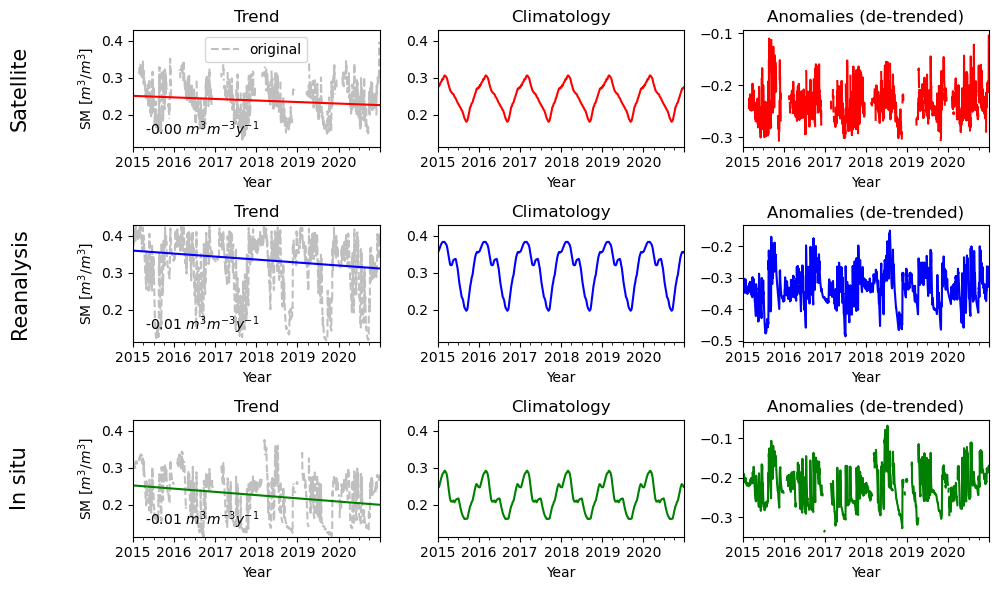

In [5]:
def calc_trend(ts) -> (pd.Series, float, float):
    x, y = ts.index.to_julian_date().values, ts.values
    slope, intercept, _, _ = theilslopes(y, x)  # slope unit = julian date (day)
    trend = pd.Series(index=ts.index, data=slope * x + intercept)
    return trend, slope, intercept


cols = ['satellite SM', 'reanalysis SM', 'in situ SM']
colors = ["red", "blue", "green"]
vrange = (DATA[cols].min().min(), DATA[cols].max().max())

fig, axs = plt.subplots(3, 3, figsize=(10, 6))
row = 0
for col in cols:
    # plot absolute values
    DATA[col].plot(linestyle='--', color='gray', alpha=0.5, ax=axs[row, 0], label='original', 
                   legend=True if row == 0 else False)
    # plot trend
    trend, slope, _ = calc_trend(DATA[col].dropna().copy())
    trend.plot(ax=axs[row, 0], style='-', color=colors[row], xlabel="Year", title='Trend', ylabel="SM [$m^3/m^3$]", ylim=vrange)
    # plot climatology and detrended anomalies
    clim = calc_climatology(DATA[col].copy())
    dat = calc_anomaly(DATA[col].copy(), climatology=clim, return_clim=True)
    axs[row, 0].text(x=0.05, y=0.1, s=f"{slope*365:.2f} "+"$m^3 m^{-3} y^{-1}$", transform=axs[row, 0].transAxes)
    dat['climatology'].plot(ax=axs[row, 1], style='-', color=colors[row], xlabel="Year",
                           title='Climatology', ylim=vrange)
    (dat['anomaly'] - trend).plot(ax=axs[row, 2], style='-', color=colors[row], xlabel="Year",
                       title='Anomalies (de-trended)')
    axs[row, 0].text(s=col.replace(' SM', '').capitalize(), x=-0.5, y=0.5, transform=axs[row, 0].transAxes, 
                     rotation=90, verticalalignment='center', fontsize=15)
    DATA[f"{col} Anomaly"] = dat['anomaly']
    DATA[f"{col} Climatology"] = dat["climatology"]
    DATA[f"{col} Trend"] = trend
    row += 1

plt.tight_layout()

## Plotting data distributions

Some differences are due to missing data points in the satellite and in situ time series

In [6]:
@widgets.interact(
    comp=widgets.Dropdown(
        options=['Absolute Values', 'Anomalies'],
        description='Select Data to use:', style={'description_width': '120px'}, layout=widgets.Layout(width='300px'))
)
def compute_dist(comp):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    
    colors = ['red', 'blue', 'green']
    cols = [f'{c} Anomaly' if comp == 'Anomalies' else c for c in ['satellite SM', 'reanalysis SM', 'in situ SM']]
    for i, col in enumerate(cols):
        dat = DATA[col]
        sns.histplot(dat, color=colors[i], kde=True, bins=10, cumulative=False, stat="probability", ax=axs[i])
        axs[i].set_title(col.replace(' SM', '').capitalize())
        text = (f"med={dat.median():.2f}\n" f"std={dat.std():.2f}\n"
                f"min={dat.min():.2f}\n" f"max={dat.max():.2f}")
    
        axs[i].legend([utils._l], [text], loc="best", frameon=True, handlelength=0, handletextpad=0, fontsize=9)
    
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='Select Data to use:', layout=Layout(width='300px'), options=('Abso…

## Testing for stationarity

A low p-value indicates that the time series is NOT stationary

In [7]:
# TODO: indicate what stats mean

# Testing for stationarity via Augumented-Dickey Fuller Test
prods = ['satellite SM', 'reanalysis SM', 'in situ SM']
stats = pd.DataFrame(index=['Test statistic', 'p-value'],
                     columns=pd.MultiIndex.from_product([prods, ['Absolute', 'Anomaly']]),
                     data=np.nan)

for i, col in enumerate(stats.columns.values):
    name = ' '.join(col).replace(' Absolute', '')
    res = adfuller(DATA[name].dropna())
    stats.loc['Test statistic', col] = round(res[0], 3)
    # Only if the p-value were to be close to significant, the critical values should be used to judge the hypothesis rejection
    stats.loc['p-value', col] = round(res[1], 5)
    if i == 0:
        for key, value in res[4].items():
            print(f"{key} critical value: {round(value, 3)}")

stats

1% critical value: -3.435
5% critical value: -2.863
10% critical value: -2.568


satellite SM         reanalysis SM         in situ SM        
                   Absolute Anomaly      Absolute Anomaly   Absolute Anomaly
Test statistic     -3.98200 -13.086      -4.43900   -6.83     -6.564  -9.128
p-value             0.00151   0.000       0.00025    0.00      0.000   0.000

## Correlation Analysis

In [8]:
@widgets.interact(
    comp=widgets.Dropdown(
        options=['Absolute SM Values', 'SM Anomalies'],
        description='Select Data to use:', style={'description_width': '120px'}, layout=widgets.Layout(width='300px'))
)
def compute_xcorr(comp):
    global CORR
    col, pearson_sat, pearson_rean = np.array([]), np.array([]), np.array([])
    pfix = ' Anomaly' if comp == 'SM Anomalies' else ''
    for param in DATA.columns:
        if ' SM' in param:
            continue
        dat = DATA[[f"reanalysis SM{pfix}", param]].dropna()  # keep only common obs
        r_rean = scipy.stats.pearsonr(dat[f'reanalysis SM{pfix}'].values, dat[param].values)[0]
        dat = DATA[[f'satellite SM{pfix}', param]].dropna()  # keep only common obs
        r_sat = scipy.stats.pearsonr(dat[f'satellite SM{pfix}'].values, dat[param].values)[0]
        col = np.append(col, param)
        pearson_sat = np.append(pearson_sat, float(r_sat))
        pearson_rean = np.append(pearson_rean, float(r_rean))
    
    order = np.argsort(pearson_rean)
    CORR = pd.DataFrame(index=col[order], data={'Satellite': pearson_sat[order], 'Reanalysis': pearson_rean[order]})
    
    ax = CORR.plot.barh(xlabel='Correlation [-]', color=["red", "blue"])
    ax.set_title("Soil Moisture Correlation with Reanalysis variables")

interactive(children=(Dropdown(description='Select Data to use:', layout=Layout(width='300px'), options=('Abso…

## Lag analysis
Exploring temporal cross-correlations between the reanalysis soil moisture and other variables. Short-term (event-based, a few days) and long-term (seasonal, multiple months) patterns are expected.

In the short term (a few days):
- For events causing changes in soil moisture, POSITIVE lags are expected (e.g. rainfall)
- For events caused by changes in soil moisture, NEGATIVE lags are expected (e.g. evaporation, vegetation decline)


In [9]:
def cross_corr(df, lag=0):
    """Correlation between 2 columns, where one is delayed by n days (lag)"""
    col1, col2 = df.columns
    if col1 == col2:  # Autocorrelation case
        return df.iloc[:, 0].autocorr(lag=lag)
    else:
        return df[col1].corr(df[col2].shift(lag))

@widgets.interact(
    lag_range=widgets.IntRangeSlider(
        value=(-100, 100), min=-366, max=366, step=3, description="Lag [days]", 
        layout=widgets.Layout(width='400px'), continuous_update=False, style={'description_width': '120px'}))

def compute_xcrorr(lag_range):
    lags = np.arange(*lag_range)
    n_rows, n_cols = 5, 4
    params = ["reanalysis SM"] + list(CORR.index.values[::-1])
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 10))
    
    i = 0
    for r in range(n_rows):
        for c in range(n_cols):
            if i >= len(params):
                break
            p = params[i]
            xcorr = [cross_corr(DATA[["reanalysis SM", p]], lag=lag) for lag in lags]
            axs[r, c].plot(lags, xcorr, linewidth=1, color='orange' if p == "reanalysis SM" else "blue")
            axs[r, c].set_ylim(-1, 1), axs[r, c].set_xlim(*lag_range)
            axs[r, c].set_xlabel("Lag [days]")
            if c == 0:
               axs[r, c].set_ylabel("R [-]")
            axs[r, c].set_title(p[:35] if p != "reanalysis SM" else "Soil Moisture (Autocorrelation)", fontsize=10)
            i += 1
        
    plt.tight_layout()

interactive(children=(IntRangeSlider(value=(-100, 100), continuous_update=False, description='Lag [days]', lay…

## Gap Analysis

### Gap Distribution

Satellite Data Gap Stats:
  Mean gap length:  4.65
  Median gap length:  1.0
  Min gap size:  1
  Max gap size:  81
  N missing:  618
  % missing data points:  28


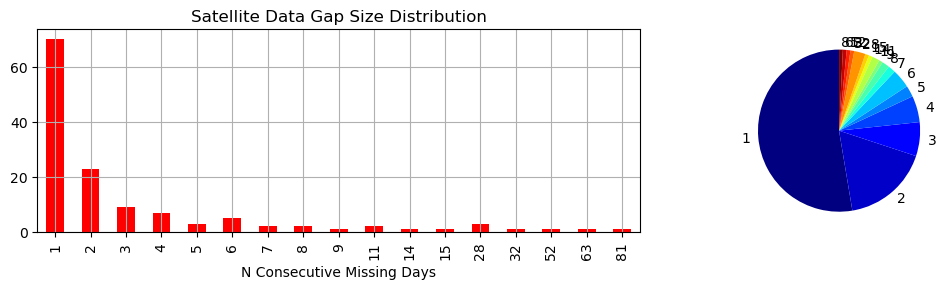

In [10]:
def count_gaps(arr, dates):
    arr = np.asarray(arr)
    # Find indices where value changes
    diff = np.diff(np.r_[0, arr, 0])

    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]

    startdates =  dates[starts]

    return pd.DataFrame(index=startdates, 
                        data={'gapsize': (ends - starts).tolist()})

gaps_df = count_gaps(np.isnan(DATA['satellite SM'].values), DATA['satellite SM'].index.values)

uniq_vals, uniq_counts = np.unique(gaps_df['gapsize'], return_counts = True)
gap_counts = pd.Series(uniq_counts, index=uniq_vals)

print("Satellite Data Gap Stats:")
print('  Mean gap length: ', round(np.mean(gaps_df.values), 2))
print('  Median gap length: ', np.median(gaps_df.values))
print('  Min gap size: ', np.min(gaps_df.values))
print('  Max gap size: ', np.max(gaps_df.values))
print('  N missing: ', np.sum(gaps_df.values))
print('  % missing data points: ', int(len(DATA[DATA['satellite SM'].isna()].index) / len(DATA.index)*100))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3), width_ratios=[0.5, 0.4])

gap_counts.plot.bar( ax=ax1, title="Satellite Data Gap Size Distribution", 
                  xlabel='N Consecutive Missing Days',
                  grid=True, color='red')
gap_counts.plot.pie(cmap=plt.get_cmap('jet'), ax=ax2, startangle=90)
fig.tight_layout()

###todo: check why hist wrong
# Hist is correct, the difference to my code comes from the time period (I counted from 2000-2020 and here we only count 2015-2020)

Check when the largest gaps appear within a year

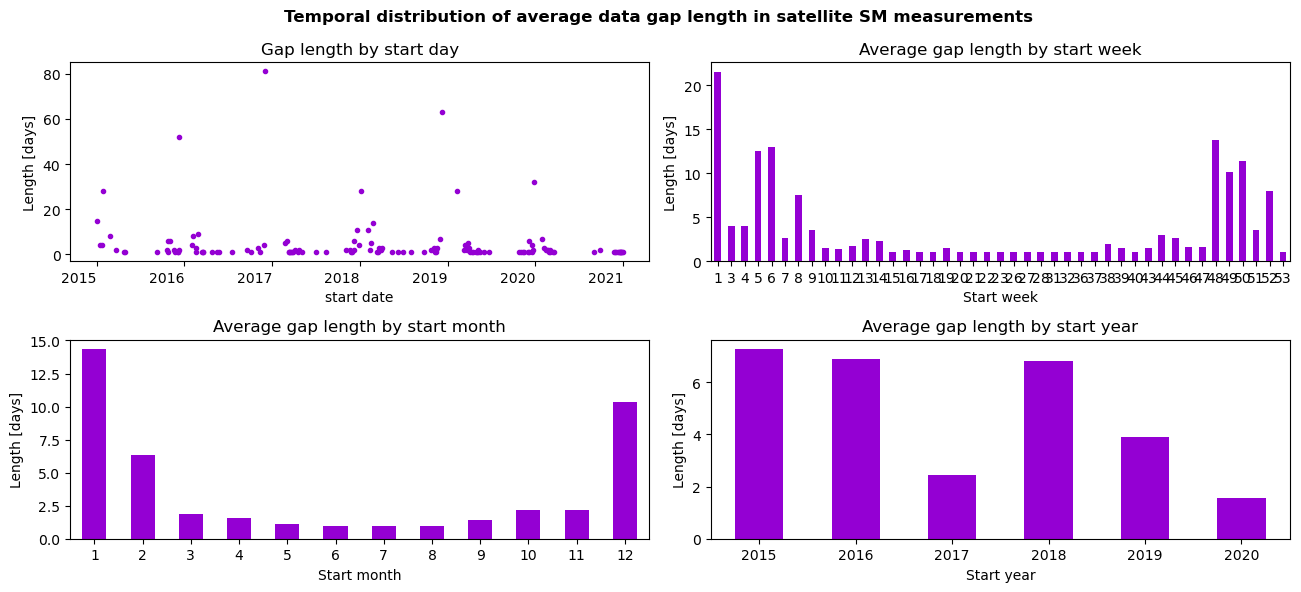

In [11]:
gaps_df['month'] = gaps_df.index.month
gaps_df['weekofyear'] = gaps_df.index.isocalendar().week
gaps_df['year'] = gaps_df.index.year

fig, axs = plt.subplots(2, 2, figsize = (13, 6))
data_gap_dates, data_gap_list = gaps_df.index.values, gaps_df.values
gaps_df['gapsize'].plot(color='darkviolet', title='Gap length by start day', rot=0,
                        marker='.', linewidth=0, ax=axs[0, 0], ylabel='Length [days]', xlabel='start date',
                       )
avg_gapsize_week = gaps_df.groupby('weekofyear').mean()['gapsize']
avg_gapsize_week.plot.bar(
    ax=axs[0, 1], ylabel='Length [days]', xlabel='Start week', color='darkviolet', 
    rot=0, title='Average gap length by start week')
avg_gapsize_month = gaps_df.groupby('month').mean()['gapsize']
avg_gapsize_month.plot.bar(
    ax=axs[1, 0], ylabel='Length [days]', xlabel='Start month', color='darkviolet', 
    rot=0, title='Average gap length by start month')
avg_gapsize_year = gaps_df.groupby('year').mean()['gapsize']
avg_gapsize_year.plot.bar(
    ax=axs[1, 1], ylabel='Length [days]', xlabel='Start year', color='darkviolet', 
    rot=0, title='Average gap length by start year')

fig.suptitle('Temporal distribution of average data gap length in satellite SM measurements', weight = 'bold')
plt.tight_layout()


In [12]:
# todo: Add strategy for systematic gaps

def markov_gaps(reference: pd.Series) -> pd.Series:
    transitions = {}
    reference.name = 'sm'
    dat = pd.DataFrame(reference)
    dat['sm_available'] = (~np.isnan(dat['sm'])).astype(int)
    dat['month_of_year'] = dat.index.month
    for month, group in dat.groupby('month_of_year'):
        x = group['sm_available'].values
        P00 = ((x[:-1]==0) & (x[1:]==0)).sum() / (x[:-1]==0).sum()
        P01 = 1 - P00
        P11 = ((x[:-1]==1) & (x[1:]==1)).sum() / (x[:-1]==1).sum()
        P10 = 1 - P11
        transitions[month] = [[P00, P01],[P10,P11]]
    
    # ** Simulate gaps 
    states = []
    current_state = 0 # Initial state
    for month_of_day in dat["month_of_year"]:
        # Get current state from previous state by random sampling according to the transition matrix
        current_state = np.random.choice([0, 1], p=transitions[month_of_day][current_state])
        states.append(current_state)
        
    dat["gaps"] = states

    return ~dat['gaps'].astype(bool)


@widgets.interact(
    strategy=widgets.Dropdown(
        options=['Satellite-like (simulated)', 'Satellite gaps (original)', 
                 '30% random', '50% random', '10% forecast'],
        description='Select Gap Strategy:', style={'description_width': '140px'}, layout=widgets.Layout(width='300px')),
)
def train_test_split(strategy):
    global PREDICTION
    PREDICTION = pd.DataFrame(data={'original': DATA['reanalysis SM'].copy()})

    if strategy == 'Satellite gaps (original)':
        PREDICTION['gaps'] = np.isnan(DATA['satellite SM'])
    elif strategy == 'Satellite-like (simulated)':
        PREDICTION['gaps'] = markov_gaps(DATA['satellite SM'])
    elif strategy.endswith("random"):
        percent_random = int(strategy.split('%')[0])
        PREDICTION['gaps'] = False
        rand_idx = sorted(np.random.choice(list(range(len(PREDICTION.index))), 
                                           size=int(len(PREDICTION.index) * (percent_random / 100)), replace=False))
        PREDICTION.iloc[rand_idx, 1] = True
    elif strategy.endswith("forecast"):
        precent = int(strategy.split('%')[0])
        PREDICTION['gaps'] = False
        N = int(len(PREDICTION.index) * (precent / 100))
        PREDICTION.iloc[slice(-N, None), 1] = True
    else:
        raise NotImplementedError()

    #Select which gap type to use
    PREDICTION['test'] = PREDICTION.loc[PREDICTION['gaps'] == True, 'original']
    PREDICTION['train'] = PREDICTION.loc[PREDICTION['gaps'] == False, 'original']

    print(f"N train = {len(PREDICTION.train.dropna())}, N test = {len(PREDICTION.test.dropna())}")

    display(PREDICTION)

interactive(children=(Dropdown(description='Select Gap Strategy:', layout=Layout(width='300px'), options=('Sat…

# Baseline Predictions
1) Forward Filling
2) Linear Interpolation
3) DCT-PLS (cosine transform fit - 2d = without spatial neighbourhood information)

In [13]:
#PREDICTION['filled_dctpls'] = pytesmo.interpolate.dctpls.smoothn(PREDICTION['train'].values.copy(), isrobust=True)[0]
PREDICTION['filled_const'] = PREDICTION['train'].ffill().bfill()
PREDICTION['filled_linear'] = PREDICTION['train'].interpolate('linear', limit_direction='both')

for col in PREDICTION.columns:  # Only keep new values
    if col.startswith('filled_'):
        PREDICTION.loc[~PREDICTION['gaps'], col] = np.nan

<Axes: title={'center': 'Baseline Predictions'}, xlabel='Date'>

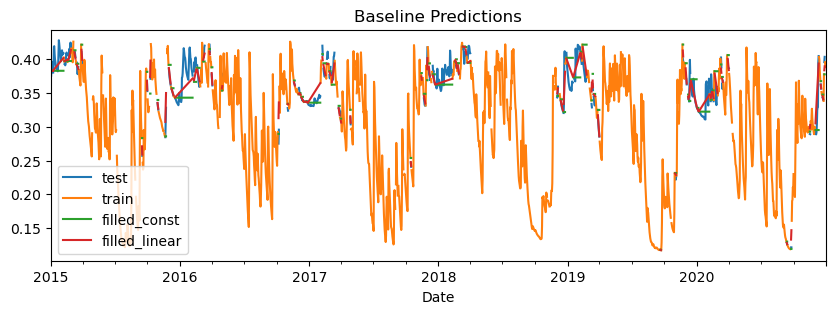

In [14]:
PREDICTION.drop(columns='original').plot(figsize=(10, 3), title='Baseline Predictions')

In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import time

In [16]:

from pathlib import Path
import re
import random


def get_era5_coords_from_filename(filename):
    """
        returns lon, lat (float) from filename (str)
    """
    pattern = re.compile(r"lon=([-+]?\d+(?:\.\d+)?)_lat=([-+]?\d+(?:\.\d+)?)")
    m = pattern.search(filename)
    if not m:
        return None, None, 
    else:  
        lon = float(m.group(1))
        lat = float(m.group(2))
        return lon, lat
    

def get_era5_files(era5_path, lat_min=-90, lat_max=90, lon_min=-180, lon_max=180, verbose=1):
    """
        returns all era5 files, which meet the regional constraint.
    """
    
    selected_files = []
    for p in era5_path.glob("*.csv"):
        
        lon, lat = get_era5_coords_from_filename(p.stem)

        check_sum = 0
        if lat >= lat_min: check_sum += 1
        if lat <= lat_max: check_sum += 1
        if lon >= lon_min: check_sum += 1
        if lon <= lon_max: check_sum += 1
        if check_sum == 4: 
            selected_files.append(str(p))
        else: 
            continue

    if verbose == 1:
        print("Selected:", len(selected_files))
    return selected_files


def process_era5_file(file, date_start='2015-01-01', date_end='2020-12-30'):

    reanalysis = pd.read_csv(file)
    reanalysis['date_time'] = pd.to_datetime(reanalysis['Unnamed: 0'])
    reanalysis = reanalysis.set_index('date_time')
    reanalysis = reanalysis.drop(columns = ['Unnamed: 0'])
    #reanalysis = reanalysis.drop(columns=['swvl2', 'swvl3', 'swvl4'])
    reanalysis = reanalysis.rename(columns={'swvl1': "sm_era5"})

    # Rainfall is ACCUMLATED over 24 hours, we use the value at 0:00 from the prev. day
    precip = (
        reanalysis[reanalysis.index.hour == 0]
        .assign(index=lambda x: x.index - pd.Timedelta(days=1))
        .set_index("index")[["tp"]]
        .asfreq("D")
    )
    reanalysis = reanalysis.resample('D').mean()
    reanalysis['tp'] = precip
    
    #reanalysis = reanalysis.rename(columns=dict(zip(original_vars, pretty_vars)))
    reanalysis = reanalysis.loc[date_start:date_end, :]
    

    return reanalysis

    
era5_path = Path("extra_era5land_europe/")
files_in_region = get_era5_files(era5_path, 
                                 lat_min=54, lat_max=60, 
                                 lon_min=5, lon_max=15)


def train_test_file_split(files, train_ratio=0.7):
    n_files = len(files)
    train_files = random.sample(files, k=round(train_ratio*n_files))
    test_files = [f for f in files if f not in train_files]
    return train_files, test_files

train_files, test_files = train_test_file_split(files_in_region, train_ratio=0.7)
print("n_train:",len(train_files))
print("n_test:", len(test_files))

Selected: 14
n_train: 10
n_test: 4


(array([-6.8536840e-03, -6.8510950e-03, -6.7568086e-03, ...,
        2.9992636e+02,  2.9992870e+02,  3.0047675e+02], shape=(33735,)), array([1, 1, 1, ..., 1, 1, 1], shape=(33735,)))


date_time
2015-01-01    0.004577
2015-01-02    0.005727
2015-01-03    0.000044
2015-01-04    0.000215
2015-01-05    0.000550
                ...   
2020-12-26    0.013016
2020-12-27    0.002711
2020-12-28    0.008190
2020-12-29    0.006389
2020-12-30    0.001608
Freq: D, Name: tp, Length: 2191, dtype: float64

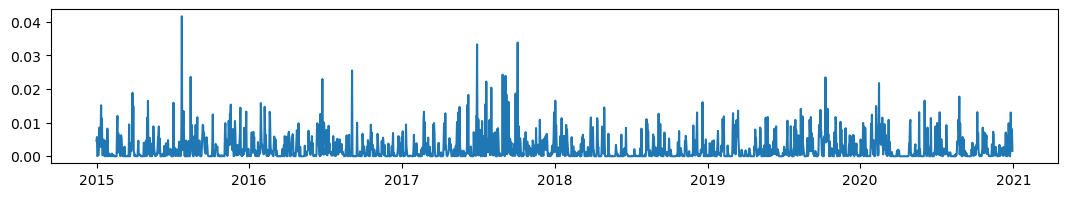

In [18]:
test = process_era5_file(train_files[0], date_start='2015-01-01', date_end='2020-12-30')
print(np.unique(test, return_counts=True))
plt.figure(figsize=(13,2))
plt.plot(test["tp"])
test["tp"]

In [19]:


def min_max_scale(data_series, min_val, max_val, out_range=[0,1]):
    return (data_series - min_val) / (max_val - min_val) * out_range[1] + out_range[0]

def min_max_rescale(data_series, min_val, max_val, out_range=[0,1]):
    return (data_series - out_range[0])/out_range[1] * (max_val - min_val) + min_val

def standard_scale(data_series, mean_val, std_val):
    return (data_series - mean_val) / std_val

def standard_rescale(data_series, mean_val, std_val):
    return (data_series * std_val) + mean_val


def encode_gaps(gap_mask: pd.Series, max_gap: int = 60) -> pd.Series:
    """ Fill gaps with consecutive counts that indicate the uncertainty"""
    gap = (gap_mask == 0)
    group = (gap_mask == 1).cumsum()
    days_since_valid = gap.groupby(group).cumsum()
    return days_since_valid.clip(upper=max_gap)



In [20]:
def get_monthly_transitions(ref_df, ref_varname) -> dict:
    transitions = {}
    dat = ref_df.copy()
    dat['sm_available'] = (~np.isnan(dat[ref_varname])).astype(int)
    dat['month_of_year'] = dat.index.month
    
    for month, group in dat.groupby('month_of_year'):
        x = group['sm_available'].values
        P00 = ((x[:-1]==0) & (x[1:]==0)).sum() / (x[:-1]==0).sum()
        P01 = 1 - P00
        P11 = ((x[:-1]==1) & (x[1:]==1)).sum() / (x[:-1]==1).sum()
        P10 = 1 - P11
        transitions[month] = [[P00, P01],[P10,P11]]
    return transitions


def simulate_gaps(df, monthly_transitions) -> list:
    """ simulate gaps for data with given transition matrix """
    states = []
    current_state = 0 # Initial state
    
    for month_of_day in df.index.month:
    # Get current state from previous state by random sampling according to the transition matrix
        current_state = np.random.choice([0, 1], p=monthly_transitions[month_of_day][current_state])
        states.append(current_state)
    return states
    
    transitions = get_monthly_transitions(DATA, "satellite SM")


with open('transitions.pickle', 'wb') as handle:
    pickle.dump(transitions, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('transitions.pickle', 'rb') as handle:
#    b = pickle.load(handle)

NameError: name 'transitions' is not defined

In [325]:
from torch.utils.data import Dataset


ALL_ERA5_FEATURES = ['lai_hv', 'lai_lv', 'tp', 'd2m', 'skt', 'stl1', 'stl2', 'stl3', 'stl4', 
                     't2m', 'evabs', 'evaow', 'evatc', 'evavt', 'pev', 'ro', 'es', 'ssro', 'sro', 'sm_era5']

class GapFillDataset(Dataset):

    def __init__(self, files,
                 date_start='2015-01-01', date_end='2020-12-30',
                 seq_len=150,
                 stride=10,
                 cache_in_memory=True,
                 monthly_transitions=None,
                 X_features=["pev", "sm_era5_with_gaps", "gap_mask"],
                 y_feature="sm_era5"):
        
        self.files = list(files)
        self.date_start = date_start
        self.date_end = date_end
        self.seq_len = int(seq_len)
        self.stride = int(stride)
        self.cache_in_memory = bool(cache_in_memory)
        self.X_features = X_features
        self.y_feature = y_feature
        self.monthly_transitions=monthly_transitions

        self._features = self.X_features + [self.y_feature]
        self._era5_features = [f for f in self._features if f in ALL_ERA5_FEATURES]
        self._timedelta_max_gap = 60


        # Get statistics for each feature from merged files
        self.statistics = self._get_multi_file_statistics()

        self._dfs = [None] * len(self.files)
        self._index = []
        

        for i in range(len(self.files)):
            df = self._get_df(i)

            max_start = len(df) - self.seq_len + 1

            if self.cache_in_memory:
                self._dfs[i] = df

            for start in range(0, max_start, self.stride):
                self._index.append((i, start))

        if len(self._index) == 0:
            raise ValueError("No samples available.")

    
    
    def _get_multi_file_statistics(self):
        """
            Merges data from all files and calculates statistics
            returned list for each feature: [min, max, mean, std]
        """
        
        # Initialize Dictionaries
        multi_file_statistics = {}
        multi_data_dict = {}
        for feature in self._era5_features:
            multi_data_dict[feature] = []
            
        # Add data within each file to dictionary
        for file in self.files:
            data = process_era5_file(file)
            for feature in self._era5_features:
                multi_data_dict[feature] = multi_data_dict[feature] + data[feature].to_list()
        
        # Calculate statistics
        for feature in self._era5_features:
            d = np.array(multi_data_dict[feature])
            multi_file_statistics[feature] = [d.min(), d.max(), d.mean(), d.std()]
        return multi_file_statistics
    

    def _get_df(self, file_i):
        """
            Given a file, it:
                1.) loads the data within
                2.) drops not selected features
                3.) scales the existing features
                4.) extracts couple of new features

            A cache is used, so all the calculations dont have to be
            carried out everytime it is called, but only once for each file
                
        """

        # If already in cache, dont rerun
        if self.cache_in_memory and self._dfs[file_i] is not None:
            return self._dfs[file_i]

        
        df_raw = process_era5_file(self.files[file_i], 
                               date_start=self.date_start,
                               date_end=self.date_end)

        # Keep only the selected ERA5 columns in the data
        df = df_raw.loc[:, self._era5_features].copy()

        df["gap_mask"] = simulate_gaps(df, self.monthly_transitions)

        # Soil Moisture (ERA5)
        _min, _max, _mean, _std = self.statistics["sm_era5"]
        df["sm_era5"] = min_max_scale(df["sm_era5"], _min, _max, out_range=[0.1,1])

        
        for feature in self._features:
            
            if feature in self.statistics:
                # Selects statistics for the current feature
                _min, _max, _mean, _std = self.statistics[feature]
            else:
                _min, _max, _mean, _std = None, None, None, None

            # Potential Evaporation / Skin Temperature
            if feature == "pev" or feature == "skt":
                df[feature] = standard_scale(df[feature], _mean, _std)

            # Total precipitation
            elif feature == "tp":
                precip_log = np.log(1 + df[feature].values)
                df[feature] = min_max_scale(df[feature], _min, _max)
            
            # Number of days since last valid Soil Moisture Value
            elif feature == "timedelta": 
                timedelta = encode_gaps(df["gap_mask"], max_gap=self._timedelta_max_gap)
                df[feature] = min_max_scale(timedelta, 0, self._timedelta_max_gap)

            # ERA5 Soil Moisture with synthetic gaps
            elif feature == "sm_era5_with_gaps":
                gap_mask = df["gap_mask"].astype(bool) 
                df[feature] = df["sm_era5"].where(gap_mask, 0)

            # Day of Year (cyclical encoded)
            elif feature == "doy_sin" or feature == "doy_cos":
                df['doy_sin'] = np.sin(2*np.pi * df.index.dayofyear / 365.25)
                df['doy_cos'] = np.cos(2*np.pi *  df.index.dayofyear / 365.25)

            elif feature == "gap_mask" or feature == "sm_era5":
                continue

            else:
                print(f"(!) Selected feature '{feature}' can not be used.\n"
                    "Usable features: 'sm_era5', 'gap_mask', 'sm_era5_with_gaps', 'pev', 'skt', 'tp', "
                    "'timedelta', 'doy_sin', 'doy_cos', 'gap_mask'")

        # Add to cache
        if self.cache_in_memory:
            self._dfs[file_i] = df
            
        return df

    
    def __len__(self):
        return len(self._index)


    def __getitem__(self, idx):
        file_i, start = self._index[idx]

        # Get full data from current file
        df = self._get_df(file_i)

        # Get data within current time window
        df_w = df.iloc[start:start+self.seq_len]

        # Output
        X = df_w[self.X_features].to_numpy(dtype=np.float32)
        y = df_w[self.y_feature].to_numpy(dtype=np.float32)
        gap_mask = df_w["gap_mask"].to_numpy(dtype=np.float32)

        return [torch.from_numpy(X), torch.from_numpy(y), torch.from_numpy(gap_mask)]





In [326]:

ds_train = GapFillDataset(files=train_files, 
                          date_start='2015-01-01', date_end='2020-12-30', #end date has to be <= 2020-12-30 (!)
                          seq_len=150, 
                          stride=30,
                          monthly_transitions=transitions,
                          X_features=["tp", "pev", "skt", "sm_era5_with_gaps", 
                                      "gap_mask", "doy_sin", "doy_cos", "timedelta"],
                          y_feature="sm_era5")
                          

train_loader = DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=0)

In [327]:
print("len(ds_train) =", len(ds_train))

X, y, gap_mask = ds_train[0]
print("X:", X.shape, X.dtype)
print("y:", y.shape, y.dtype)
print("gap_mask:", gap_mask.shape, gap_mask.dtype)
print("gap_mask unique:", torch.unique(gap_mask))


len(ds_train) = 690
X: torch.Size([150, 8]) torch.float32
y: torch.Size([150]) torch.float32
gap_mask: torch.Size([150]) torch.float32
gap_mask unique: tensor([0., 1.])


In [328]:
# Check plausibility

file_i, start = ds_train._index[0]
df = ds_train._get_df(file_i)
df_w = df.iloc[start:start+ds_train.seq_len]

print("X_features:", ds_train.X_features)
print(df_w[ds_train.X_features].head())


X_features: ['tp', 'pev', 'skt', 'sm_era5_with_gaps', 'gap_mask', 'doy_sin', 'doy_cos', 'timedelta']
                  tp       pev       skt  sm_era5_with_gaps  gap_mask  \
date_time                                                               
2015-01-01  0.104871  1.120267 -0.791478                0.0         0   
2015-01-02  0.092059  0.534982 -0.628360                0.0         0   
2015-01-03  0.000836  0.378605 -0.877151                0.0         0   
2015-01-04  0.006268  0.868034 -1.040348                0.0         0   
2015-01-05  0.014902  1.037567 -0.757745                0.0         0   

             doy_sin   doy_cos  timedelta  
date_time                                  
2015-01-01  0.017202  0.999852   0.016667  
2015-01-02  0.034398  0.999408   0.033333  
2015-01-03  0.051584  0.998669   0.050000  
2015-01-04  0.068755  0.997634   0.066667  
2015-01-05  0.085906  0.996303   0.083333  


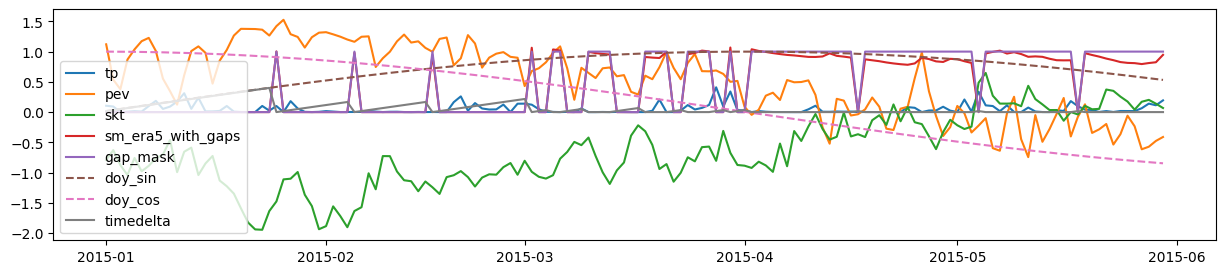

In [329]:
plt.figure(figsize=(15,3))

plt.plot(df_w[ds_train.X_features]["tp"], label="tp")
plt.plot(df_w[ds_train.X_features]["pev"], label="pev")
plt.plot(df_w[ds_train.X_features]["skt"], label="skt")
plt.plot(df_w[ds_train.X_features]["sm_era5_with_gaps"], label="sm_era5_with_gaps")
plt.plot(df_w[ds_train.X_features]["gap_mask"], label="gap_mask")
plt.plot(df_w[ds_train.X_features]["doy_sin"], "--", label="doy_sin")
plt.plot(df_w[ds_train.X_features]["doy_cos"], "--", label="doy_cos")
plt.plot(df_w[ds_train.X_features]["timedelta"], label="timedelta")
plt.legend()

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # force CPU

# Reproducibility
torch.manual_seed(123)
np.random.seed(123)
device = torch.device("cpu")


df = DATA.copy()
df["train"] = PREDICTION["train"].dropna()

def make_windows(df, features, target, window):
    """
    One (left) sided window at the target time stamp
    """
    X, y = [], []
    for i in range(window, len(df)):
        X.append(df[features].iloc[i-window:i].values)
        y.append(df[target].iloc[i])
    return np.array(X), np.array(y)

WINDOW = 150

X, y = make_windows(
    df,
    features=utils.pretty_vars,
    target="reanalysis SM",
    window=WINDOW
)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(
    X.reshape(-1, X.shape[2])).reshape(X.shape)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(
    y.reshape(-1, 1)
).flatten()


# Convert to torch tensors
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32).unsqueeze(1)

# -----------------------------
# Train / validation split
# -----------------------------
val_frac = 0.2
n_total = len(X)
n_val = int(n_total * val_frac)

X_train, X_val = X[:-n_val], X[-n_val:]
y_train, y_val = y[:-n_val], y[-n_val:]

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TimeSeriesDataset(X_train, y_train)
val_ds   = TimeSeriesDataset(X_val, y_val)

train_loader = DataLoader(
    train_ds,
    batch_size=32,
)

val_loader = DataLoader(
    val_ds,
    batch_size=32,
)


In [ ]:


# -----------------------------
# Model definition
# -----------------------------
class LSTMModel(nn.Module):
    def __init__(self, n_features, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, window, features)
        out, (h_n, c_n) = self.lstm(x)
        # Use last hidden state
        out = h_n[-1]
        out = self.fc(out)
        return out

model = LSTMModel(n_features=X.shape[2]).to(device)
print(model)

# -----------------------------
# Training setup
# -----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Early stopping (Keras-like)
patience = 10
best_val_loss = np.inf
epochs_no_improve = 0
best_state = None

# -----------------------------
# Training loop
# -----------------------------
n_epochs = 50

for epoch in range(n_epochs):
    # ---- Training ----
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)

    val_loss /= len(val_loader.dataset)

    print(
        f"Epoch [{epoch+1}/{n_epochs}] "
        f"Train Loss: {train_loss:.6f} "
        f"Val Loss: {val_loss:.6f}"
    )

    # ---- Early stopping ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break


# Save best model from current run
model_identifier = time.strftime("%Y%m%d-%H%M%S")
torch.save(best_model, "lstm_" + str(model_identifier))

print("Training done")

In [18]:
from tqdm import tqdm

# Initialize column
PREDICTION["filled_lstm"] = np.nan

model.eval()  # IMPORTANT: inference mode

with torch.no_grad():
    for i in tqdm(range(WINDOW, len(PREDICTION.index))):
        if bool(PREDICTION["gaps"].iloc[i]) is True:
            # Build window
            x = df[utils.pretty_vars].iloc[i-WINDOW:i].values
            x = torch.tensor(
                x[np.newaxis, ...],  # (1, WINDOW, n_features)
                dtype=torch.float32
            )

            # Forward pass
            y_hat = model(x)

            # Store prediction
            PREDICTION.loc[
                PREDICTION.index[i],
                "filled_lstm"
            ] = y_hat.item()

# Optional inverse scaling
PREDICTION["filled_lstm"] = scaler_y.inverse_transform(
    PREDICTION["filled_lstm"].values.reshape(-1, 1)
).flatten()

print("done")


100%|██████████| 2042/2042 [00:02<00:00, 946.19it/s] 

done


<h1>Performance Evaluation and Validation</h1>

**Strategy:**
- small gaps vs. large gaps
- seasonal differences
- different validation metrics
    - correlation coefficient (R2) + scatter plot
    - direct visual comparison in time series plot
    - MSE
    - MAE
- hyperparameters
- baseline vs. lstm
- with ERA5 ancillary variables and without
- validate on in situ data?
- Time series splits wherever data contains causal effects? Do we have causal effects in our data?

<h2>Configuration 1 (we need to decide which configurations we want to use)</h2>

In [19]:
# Distinguish between 1-day-gaps and longer gaps
PREDICTION_gaps = count_gaps(np.isnan(PREDICTION['train'].values), PREDICTION['train'].index.values)
PREDICTION_smallgaps = PREDICTION.loc[PREDICTION_gaps[PREDICTION_gaps['gapsize']==1].index.values]
PREDICTION_largegaps = PREDICTION[~ PREDICTION.index.isin(PREDICTION_gaps[PREDICTION_gaps['gapsize']==1].index)]

datasets = [PREDICTION, PREDICTION_smallgaps, PREDICTION_largegaps]
dataset_labels = ['All gaps', 'Small gaps (1 day)', 'Large gaps (> 1 day)']

**1. Correlation coefficient and visual comparison**

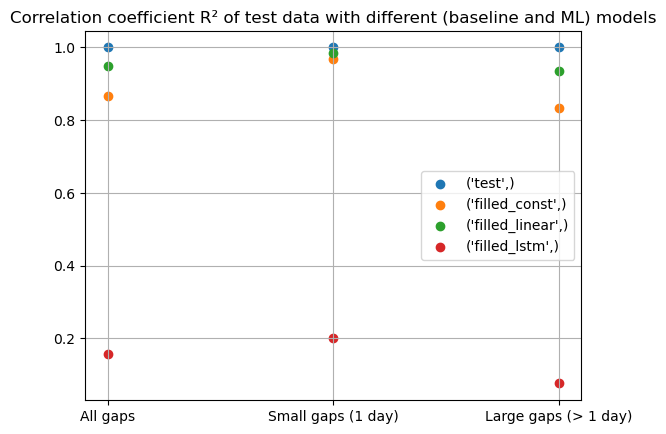

In [139]:
plot_df = pd.DataFrame(columns = dataset_labels, index = [['test'] + [c for c in PREDICTION.columns if c.startswith('filled')]])

for i, dataset in enumerate(datasets):
    corr_df = dataset[['test'] + [c for c in dataset.columns if c.startswith('filled')]].corr()
    plot_df[dataset_labels[i]] = corr_df['test'].values

for model in plot_df.index:
    plt.scatter(plot_df.columns, plot_df.loc[model], label = model)

plt.legend()
plt.title('Correlation coefficient R² of test data with different (baseline and ML) models')
plt.grid()

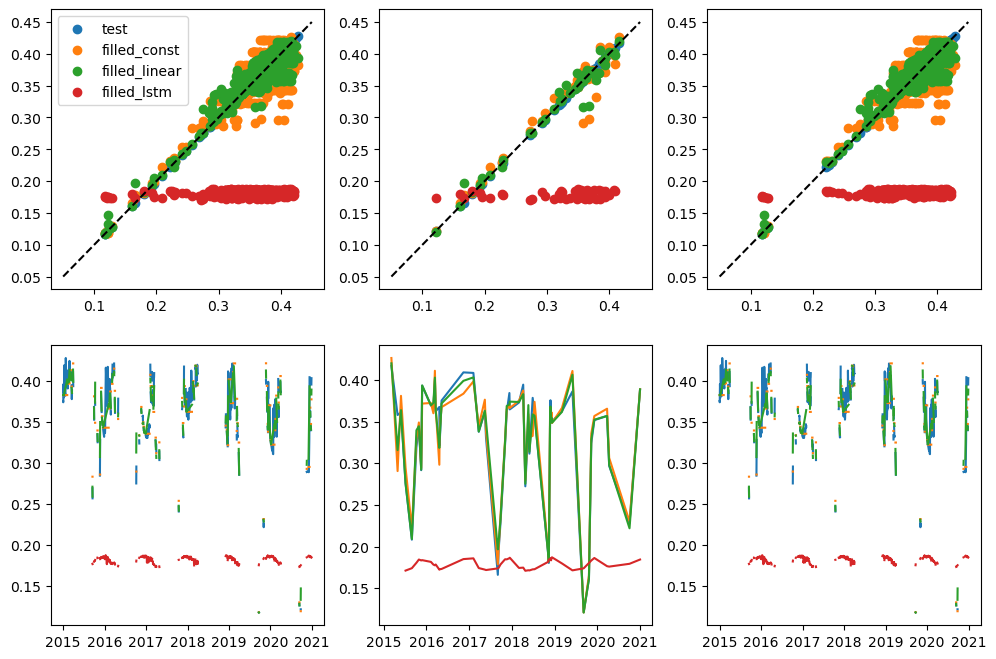

In [168]:
fig, ax = plt.subplots(2,3, figsize = (12,8))

for i, dataset in enumerate(datasets):  
    ax[0,i].plot(np.arange(0.05,0.5,0.1), np.arange(0.05,0.5,0.1), c = 'black', linestyle = 'dashed')

    for j, model in enumerate(['test'] + [c for c in dataset.columns if c.startswith('filled')]):    
        ax[0,i].scatter(dataset['test'], dataset[model], label = model) 
        ax[1,i].plot(dataset[model], label = model)
        
ax[0,0].legend()

**MSE, MAE**

In [20]:
models = [c for c in PREDICTION.columns if c.startswith('filled')]

mae = [abs(PREDICTION[model]-PREDICTION['original']).mean() for model in models]
mse = [((PREDICTION[model]-PREDICTION['original'])**2).mean() for model in models]

mean_errors = pd.DataFrame(data = {'mae': mae, 'mse': mse}, index = models)

mean_errors

,mae,mse
filled_const,0.017213,0.000577
filled_linear,0.010866,0.000230
filled_lstm,0.169890,0.030512


**Seasonal comparison**